In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #stylish visualization
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.5)

import matplotlib.pyplot as plt # visualization

#scikitlearn package
#from imblearn.under_sampling import RandomUnderSampler

plt.rcParams["figure.figsize"] = [10, 8]

# Unbalanced Classes

**Classification** is the general term for supervised learning problems where we try to predict the value of a categorical variable.  That is, we want to build a model $f$ that approximates the relationship between features $X$ and labels $y$ so that 

$$ f(X_j) = y_j $$

for most observations $(X_j,y_j)$.  Here the $y_j$ come from a finite set of labels, and we often refer to the groups defined by these labels as classes.  We say that a classification problem is **binary** if there are two classes, and **multiclass** otherwise.

## Logistic regression

We will build a logistic regression model. It is a fairly simple algorithm that builds a probabilistic model by rescaling the output of a linear function. Feature values of observation $X_j$ are combined linearly using coefficients in the same way as in linear regression, but a key difference from linear regression is that the output of the linear function is passed through the **sigmoid function** which returns the probability of observation $X_j$ being in class 1. For binary classification where we only have two classes, if $P(y_j=1)$ is predicted probability of observation $X_j$ being in class 1, then the predicted probability of being in the other class equals $1 - P(y_j=1)$. In the default version of logistic regression, the class with the highest predicted probability becomes the predicted label. 

We can write the predicted probability of observation $X_j$ being in class 1 as:

$$ P(y_j=1) = f(X_j) = S\left( X_j\beta + \beta_0 \right) = S\left(\sum_i X_{ji}\beta_i + \beta_0 \right)$$

where $\beta$ is a column vector of coefficients and $\beta_0$ is an intercept term as in linear regression, and $S$ denotes the sigmoid function (also called logistic function)

$$ S(z) = \frac{1}{1+e^{-z}}\,$$

which maps $\mathbb{R}$ to $(0,1)$.  

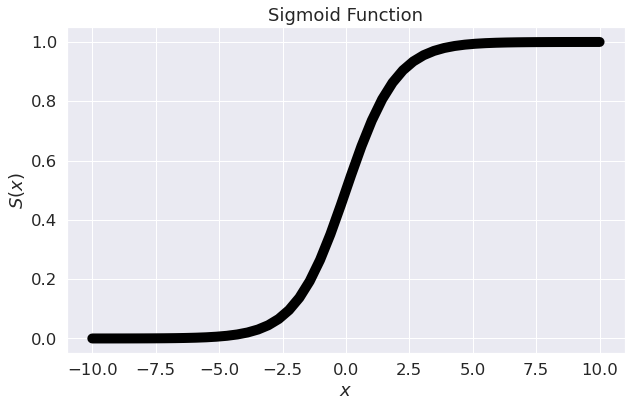

In [2]:
import numpy as np
plt.figure(figsize=(10,6))
lx = np.linspace(-10, 10)
ly = np.exp(lx) / (1 + np.exp(lx))
plt.plot(lx, ly, 'k-', lw=10)
plt.title('Sigmoid Function')
plt.xlabel(r'$x$')
plt.ylabel(r'$S(x)$');

In this notebook we will build a model that uses transactions made by credit cards in September 2013 by European cardholders. All features except 'Time' and 'Amount' have been transformed with PCA. The feature 'Class' gives label 1 for frauduelent and 0 for non-fraudulent. We will introduce logistic regression and classification metrics. Confusion matrix accuracy is not meaningful for unbalanced classification.

## Introduction: Credit Card Fraud Detection

![Fraud Detection](images/1_QHFaJP0GE4fAI05wR4jxZQ.jpeg)

In [3]:
#data
df_credit = pd.read_csv('small_data/creditcard.csv')
df_credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### `'Class'` is the column that describes the category (fraud/non-fraud) of customers. We will build a classifier by  using all features. We can see this is clearly imbalance data as shown here below.

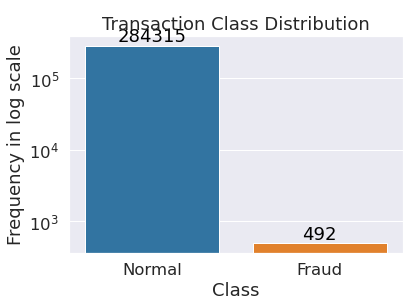

In [4]:
#df_credit.Class.value_counts()
ax = sns.countplot(x = df_credit.Class)
LABELS = ["Normal", "Fraud"]
plt.title('Transaction Class Distribution')
plt.xticks(range(2), LABELS) 
plt.xlabel("Class")
plt.ylabel("Frequency in log scale")
plt.yscale('log')

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='bottom', color='black', size=18)
    
plt.show();

## Visualization using two features only

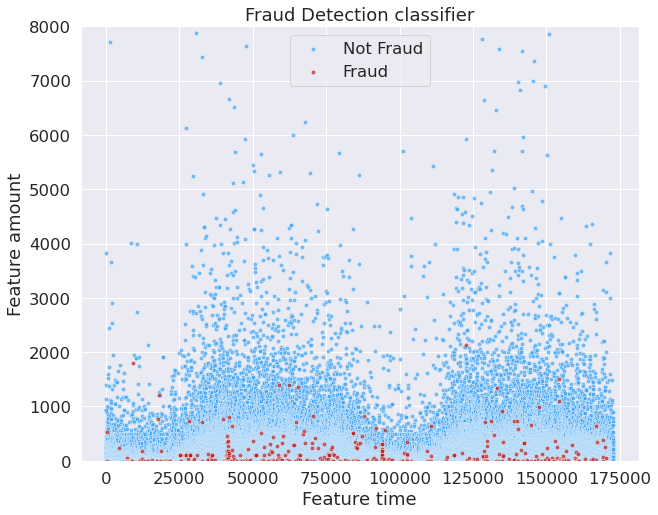

In [25]:
import matplotlib.pyplot as plt

feature_2 = 'Amount'
feature_1 = 'Time'
cat_dict = {1: 'Fraud', 0: 'Not Fraud'}
color_dict = {1: '#ba2121ff', 0: '#42a5f5ff'}

groups = df_credit.groupby('Class')
for name, group in groups:
    plt.scatter(group[feature_1], group[feature_2], edgecolor='w', lw=0.5,
                s=20, alpha=0.7, label=cat_dict[name], c=color_dict[name])
plt.ylim(-10, 8000)    
plt.title('Fraud Detection classifier')
plt.xlabel('Feature {}'.format(feature_1.lower()))
plt.ylabel('Feature {}'.format(feature_2.lower()))
plt.legend();

## Training a classifier

#### Let's train scikit-learn's [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier on the customer data and make some predictions.

In [6]:
from sklearn.model_selection import train_test_split

X = df_credit.drop(['Class'], axis=1)
y = df_credit['Class']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
print('Shape of the complete data set:', X.shape)
print('Shape of the training data set:', X_train.shape)
print('Shape of the validation data set:', X_valid.shape)

Shape of the complete data set: (284807, 30)
Shape of the training data set: (199364, 30)
Shape of the validation data set: (85443, 30)


In [7]:
from sklearn.model_selection import train_test_split

X = df_credit.drop(['Class'], axis=1)
y = df_credit['Class']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, \
                                                      test_size=0.3, random_state=42)

Now our data is ready to be passed into a scikit-learn predictor. Let's first try a logistic regression model. We can simply make a `LogisticRegression` object and train it on the transformed data matrix.

## Create a pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

lr_pipe = Pipeline([('scaler', StandardScaler()),
                    ('lr', LogisticRegression())])

lr_pipe.fit(X_train, y_train);

In [9]:
test_predictions = lr_pipe.predict(X_valid) # make predictions
print('Predictions for the first 5 observations from the validation data set:')
print(test_predictions[:5])
pd.value_counts(test_predictions)

Predictions for the first 5 observations from the validation data set:
[1 0 0 0 0]


0    85345
1       98
dtype: int64

## Classification metrics: Accuracy?

The most obvious classification metric is **accuracy**, which is ``defined as the number of correct predictions divided by the total number of observations``. Let's compute the accuracy of our model on the training data.

In [10]:
from sklearn import metrics

y_pred = lr_pipe.predict(X_valid)  # model predictions

print("Training accuracy: {:.4f}".format(metrics.accuracy_score(y_pred, y_valid)))
print("ROC accuracy: {:.4f}".format(metrics.roc_auc_score(y_pred, y_valid)))

Training accuracy: 0.9993
ROC accuracy: 0.9385


We have trained a classification model and we get some predictions but which metric should we use to evaluate how good the model is? As in the above case, the **accuracy** is around 80 - 99 \%. One thing we should not forget is that in the data set we received, 90% of the images come from non-fraudulent customers. This means that our model is no better than saying that every customers in the data set is non-fraudulent(baseline).

This is a typical example of class imbalance.

## Other Classification metrics: precision and recall

When accuracy is not a useful metric, we can instead focus on the uncommon class and use the concepts of **precision** and **recall**, respectively. 

In the figure below, non-fraudulent customers are represented in blue and fraudulent customers are red. We pick the "fraudulent" class to be the **positive class**. The arrows denote the predictions of our model. A blue arrow means the classifier predicts the customer is non-fraudulent and a red arrow means it predicts the customer is fraudulent. 

![errors](images/PML_precision_recall.svg)

* **Precision** is defined as the number of true positives divided by the number of all positive *predictions*. Maximizing precision means **minimizing false positives**.
* **Recall** is defined as number of true positives divided by the number all positive *observations*. Maximizing recall means **minimizing false negatives**

Let's compute all of these metrics on the training data set for our classifier.

In [11]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_valid, test_predictions, labels=[0, 1], target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85307
       Fraud       0.88      0.63      0.74       136

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



A more detailed view of the predictions for each class can be obtained by looking at the confusion matrix, which displays the actual number of cases that are predicted in to be in each class. However, confusion matrix is **suitable more in balanced classes**.

## Improving the model: random forest classifier

We will make a couple of helper functions that we can call once we have a trained model and want to evaluate it on the test data and print out the results. 

In [12]:
from sklearn import metrics

def model_evaluation(model, X, y_true):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred), 4)
    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, probs)
    scores['area under precision-recall curve'] = round(metrics.auc(recalls, precisions), 4)
    return scores

def print_model_evaluation(model_name, scores):
    print('{} evaluation \n'.format(model_name))
    for metric, score in scores.items():
        print('Test {}: {}'.format(metric, score))

## Random Forrest

Let's compare the two models we built in this notebook using our testing data set and visualize their performance by plotting the precision-recall curve.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_pipe = Pipeline([('rf', RandomForestClassifier(n_estimators=20, random_state=42))])

rf_gs = GridSearchCV(rf_pipe, 
                     cv=5, 
                     param_grid={'rf__max_depth': range(3, 9)}
                    )
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(n_estimators=20,
                                                               random_state=42))]),
             param_grid={'rf__max_depth': range(3, 9)})

In [15]:
print('Accuracy score: {:.4f}'.format(metrics.accuracy_score(y_valid,y_pred)))
print('ROC Accuracy: {:.4f}'.format(metrics.roc_auc_score(y_valid,y_pred)))

Accuracy score: 0.9993
ROC Accuracy: 0.8161


In [16]:
# Classification Report
predictions = rf_gs.predict(X_valid)
print(classification_report(y_valid, y_pred, labels=[0, 1], target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85307
       Fraud       0.88      0.63      0.74       136

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



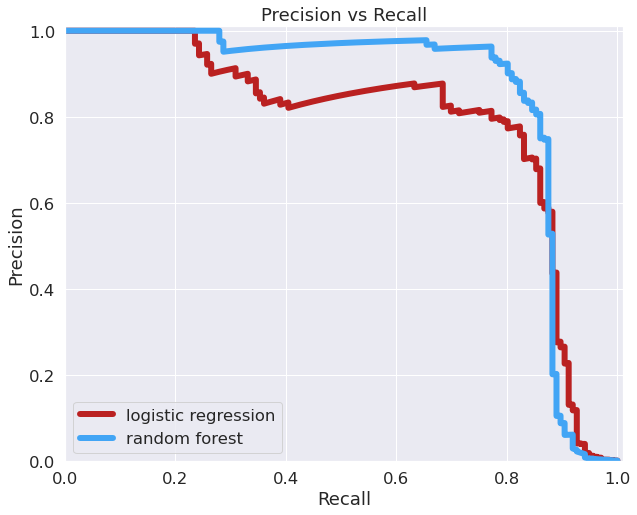

In [19]:
import matplotlib.pyplot as plt

precisions_lr, recalls_lr, thresholds = metrics.precision_recall_curve(y_valid,
                                                                 lr_pipe.predict_proba(X_valid).T[1])
precisions_rf, recalls_rf, thresholds = metrics.precision_recall_curve(y_valid,
                                                                 rf_gs.predict_proba(X_valid).T[1])

plt.plot(recalls_lr, precisions_lr, c='#ba2121ff', label='logistic regression', lw=6)
plt.plot(recalls_rf, precisions_rf, c='#42a5f5ff', label='random forest', lw = 6)
plt.xlim([0., 1.01])
plt.ylim([0., 1.01])
plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.legend();

As we already established, the random forest classifier performs much better than logistic regression on this data. Based on this precision-recall plot, for a random forest model we could choose a threshold that would give us, for example, 0.6 precision and above 0.8 recall.

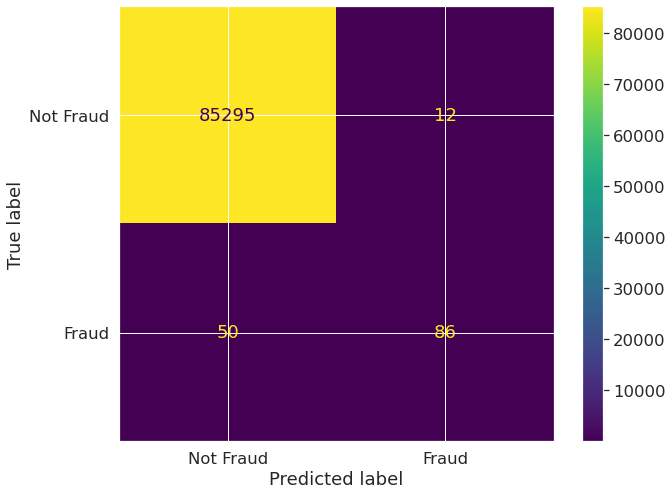

In [20]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_valid, test_predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Fraud', 'Fraud'])
_ = disp.plot()

## Probabilistic models

In addition to predicting labels, we can get the raw probabilities that the model predicts for each class using the `predict_proba` method of `LogisticRegression`. Let's look at the probabilities that the model predicts for each class for the first several observations. Make sure you understand the output of the cell below.

In [21]:
first_5_pred_prob = lr_pipe.predict_proba(X_valid[:5])
print('Predicted probabilities for each class:')
print(first_5_pred_prob)

Predicted probabilities for each class:
[[1.37465022e-08 9.99999986e-01]
 [9.99911546e-01 8.84538617e-05]
 [9.99940151e-01 5.98489795e-05]
 [9.99282026e-01 7.17974399e-04]
 [9.99915219e-01 8.47808857e-05]]


In [22]:
#probabilities

# Get prediction probabilities

probabilities = lr_pipe.predict_proba(X_valid)[:, 1]
# Get predictions using normal threshold of 0.5
print(probabilities)
pd.value_counts(probabilities > 0.5)

[9.99999986e-01 8.84538617e-05 5.98489795e-05 ... 1.60213887e-03
 2.69026135e-04 9.18159333e-04]


False    85345
True        98
dtype: int64

## Additional approaches

In addition to using a metric sensitive to imbalance and to resampling the data set in the attempt to rebalance the class ratio, it is possible to modify the model too. Options include:

- **Use ROC curve** to evaluate how precision and recall are traded depending on the value of a threshold, if the classifier allows it. See [here for an example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#example-model-selection-plot-roc-py).

- **Penalizing the majority class**: use a model that allows to set different weights for the different classes. See [here for an example](http://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html).

- **Anomaly/outlier detection**: consider the problem as an anomaly detection problem and use the majority class to train a model. See [here for a couple of examples](http://scikit-learn.org/stable/modules/outlier_detection.html).


Other ideas can be found [here](https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set).

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

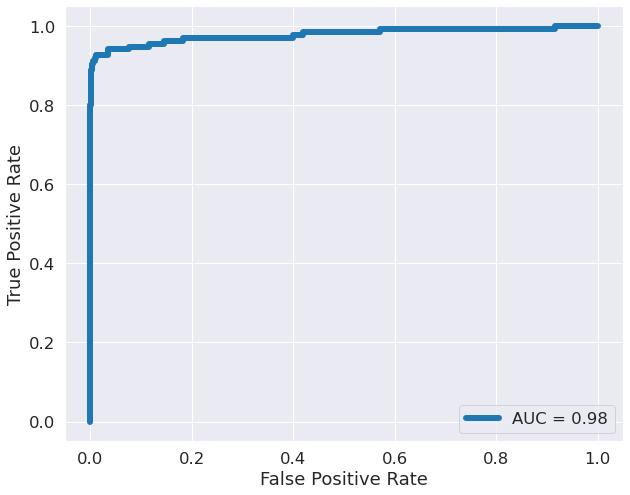

In [24]:
# ROC & AUC
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay, roc_curve
#auc(fprs, tprs)
fprs, tprs, thresholdss = roc_curve(y_valid, probabilities)
roc_auc = auc(fprs, tprs)
display = RocCurveDisplay(fpr=fprs, tpr=tprs, roc_auc=roc_auc)
_ = display.plot(lw=6)